# Marktstammdatenregister
https://www.marktstammdatenregister.de/MaStR/Datendownload

In [15]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
# params
dir = 'data/Marktstammdatenregister'

solar = 'EinheitenSolar'
wind = 'EinheitenWind'

get_dataframes = False
save_plot = True

solar_attributes = ['EinheitMastrNummer',
                    'EinheitBetriebsstatus', 
                    'Postleitzahl',
                    'Inbetriebnahmedatum',
                    'DatumEndgueltigeStilllegung',
                    'Breitengrad',
                    'Laengengrad',
                    'Nettonennleistung',
                    'AnzahlModule',
                    'Hauptausrichtung',
                    'HauptausrichtungNeigungswinkel']

wind_attributes = ['EinheitMastrNummer',
                   'EinheitBetriebsstatus',
                   'Postleitzahl',
                   'Inbetriebnahmedatum',
                   'DatumEndgueltigeStilllegung',
                   'Breitengrad',
                   'Laengengrad',
                   'Nettonennleistung',
                   'Nabenhoehe',
                   'Rotordurchmesser',
                   'NameWindpark',
                   'Hersteller',
                   'Technologie',
                   'Typenbezeichnung',
                   'Kuestenentfernung']

mapping = {
    1586.0: 'Enercon',
    1660.0: 'Vestas',
    1628.0: 'Nordex',
    1627.0: 'Nordex',
    1646.0: 'Siemens',
    1593.0: 'Fuhrlaender',
    1645.0: 'Senvion',
    2880.0: 'Senvion',
    1654.0: 'Tacke',
    1598.0: 'GE Vernova',
    1597.0: 'GE Vernova',
    1625.0: 'Nordtank',
    2889.0: 'AN Bonus',
    1584.0: 'Dewind',
    1572.0: 'Adwen',
    2873.0: 'GE Vernova',
    1587.0: 'Eno Energy',
    1652.0: 'Suedwind',
    1657.0: 'Vensys',
    1585.0: 'EasyWind',
    1596.0: 'Gamesa'
}

os.makedirs('figs', exist_ok=True)

In [3]:
def extract_sort_key(filepath):
    match = re.search(r'/(.+?)_(\d+)\.xml$', filepath)
    if match:
        category = match.group(1)
        number = int(match.group(2)) 
    else:
        category = filepath.split('/')[-1]
        number = float('inf')
    return category, number

def get_list(dir, feature):
    file_names = os.listdir(dir)
    paths = [os.path.join(dir, file) for file in file_names]
    paths = [path for path in paths if feature in path]
    paths = sorted(paths, key=extract_sort_key)
    return paths

def read_xml(file_path):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        print(f"XML-Datei erfolgreich eingelesen: {file_path}")
        return root
    except ET.ParseError as e:
        print(f"Fehler beim Einlesen der XML-Datei: {e}")
        return None
    except FileNotFoundError:
        print(f"Datei nicht gefunden: {file_path}")
        return None
    
def xml_to_df(paths: list,
              attributes: list) -> pd.DataFrame:
    data = []
    for path in paths:
        root = read_xml(path)
        for ele in root:
            row = {k: None for k in attributes}
            for attr in ele:
                if attr.tag in attributes:
                    row[attr.tag] = attr.text
            data.append(row)
    df = pd.DataFrame(data=data, columns=attributes)
    return df

In [68]:
if get_dataframes:
    solar_paths = get_list(dir, solar)
    wind_paths = get_list(dir, wind)

    df_solar = xml_to_df(paths=solar_paths,
                        attributes=solar_attributes)

    df_wind = xml_to_df(paths=wind_paths, 
                        attributes=wind_attributes)

    df_solar.to_csv(os.path.join(dir, 'Solar_MaStR.csv'), index=False)
    df_wind.to_csv(os.path.join(dir, 'Wind_MaStR.csv'), index=False)

In [69]:
df_solar = pd.read_csv(os.path.join(dir, 'Solar_MaStR.csv'))
df_wind = pd.read_csv(os.path.join(dir, 'Wind_MaStR.csv'))

df_solar['Inbetriebnahmedatum'] = pd.to_datetime(df_solar['Inbetriebnahmedatum'])
df_wind['Inbetriebnahmedatum'] = pd.to_datetime(df_wind['Inbetriebnahmedatum'])
df_wind['DatumEndgueltigeStilllegung'] = pd.to_datetime(df_wind['DatumEndgueltigeStilllegung'])
df_solar['DatumEndgueltigeStilllegung'] = pd.to_datetime(df_solar['DatumEndgueltigeStilllegung'])

/tmp/ipykernel_743682/1594805909.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_solar = pd.read_csv(os.path.join(dir, 'Solar_MaStR.csv'))


In [70]:
def plot_distribution(series: pd.Series,
                      title: str = '',
                      x_label: str = '',
                      bins: int = None,
                      binwidth: int = None,
                      save_name: str = '',
                      save_plot = False):
    if bins and not binwidth:
        sns.histplot(data=series, kde=False, stat='probability', bins=bins)
    else:
        sns.histplot(data=series, kde=False, stat='probability', binwidth=binwidth)
    plt.title(title)
    plt.xlabel(x_label)
    if save_plot:
        plt.savefig(os.path.join('figs', save_name), dpi=600)

def exclude_outliers(series: pd.Series,
                     q_high: float = 0.99,
                     q_low: float = 0.0) -> pd.Series:
    q_high = series.quantile(q_high)
    q_low = series.quantile(q_low)
    mask = (series < q_high) & (series > q_low)
    return series[mask]

def get_lifetime(data: pd.DataFrame) -> pd.Series:
    deactivated = data[~data['DatumEndgueltigeStilllegung'].isna()]
    lifetime = deactivated['DatumEndgueltigeStilllegung'] - deactivated['Inbetriebnahmedatum']
    lifetime = lifetime.dt.days / 365
    return lifetime

def get_age(data: pd.DataFrame,
            q_high: float = 1) -> pd.Series:
    age = datetime.now() - data['Inbetriebnahmedatum']
    age = age.dt.days / 365
    age = exclude_outliers(series=age, q_high=q_high)
    return age

def plot_without_outliers(series: pd.Series,
                          x_label: str = '',
                          bins: int = 20,
                          q_high: float = 0.99,
                          q_low: float = 0.0):
    series = exclude_outliers(series=series, q_high=q_high, q_low=q_low)
    plot_distribution(series=series, 
                      x_label=x_label,
                      bins=bins)
    
def auto_plot_without_outliers(data: pd.DataFrame,
                               features: list,
                               bins: int = 20,
                               q_high: float = 0.99,
                               q_low: float = 0.0):
    for feature in features:
        series = data[feature]
        if (series.dtype != 'float64') & (series.dtype != 'int64'):
            continue
        series = exclude_outliers(series=series, q_high=q_high, q_low=q_low)
        plot_distribution(series=series, 
                        x_label=feature,
                        bins=bins)

## Solar Analysis

In [71]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4869174 entries, 0 to 4869173
Data columns (total 11 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   EinheitMastrNummer              object        
 1   EinheitBetriebsstatus           int64         
 2   Postleitzahl                    object        
 3   Inbetriebnahmedatum             datetime64[ns]
 4   DatumEndgueltigeStilllegung     datetime64[ns]
 5   Breitengrad                     float64       
 6   Laengengrad                     float64       
 7   Nettonennleistung               float64       
 8   AnzahlModule                    float64       
 9   Hauptausrichtung                float64       
 10  HauptausrichtungNeigungswinkel  float64       
dtypes: datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 408.6+ MB


Drop rows with launch dates before 1985.

In [72]:
df_solar.drop(df_solar[df_solar['Inbetriebnahmedatum'] < '1985-01-01'].index, inplace=True)

Duration of operation

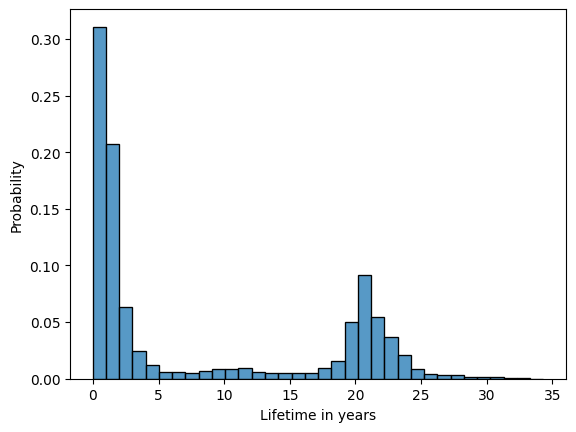

In [73]:
lifetime = get_lifetime(data=df_solar)
plot_distribution(series=lifetime, 
                  x_label='Lifetime in years', 
                  binwidth=1)

Exclude the closed systems.

In [74]:
df_solar.drop(df_solar[df_solar['EinheitBetriebsstatus'] != 35].index, inplace=True)

### Age of the system

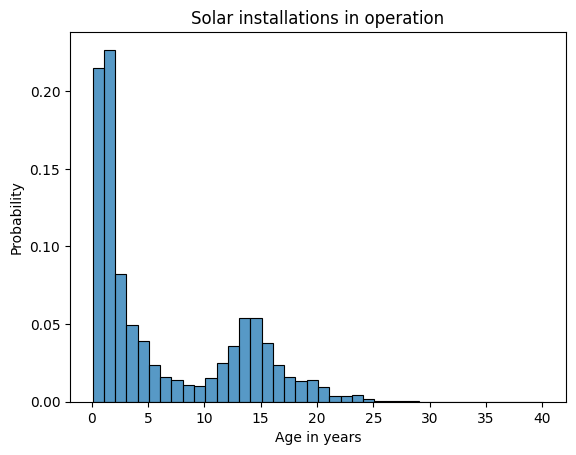

In [79]:
age = get_age(data=df_solar, q_high=1)
plot_distribution(series=age,
                  title='Solar installations in operation', 
                  x_label='Age in years',
                  binwidth=1,
                  save_plot=save_plot,
                  save_name='pv_age.png')

## Net Nominal Power

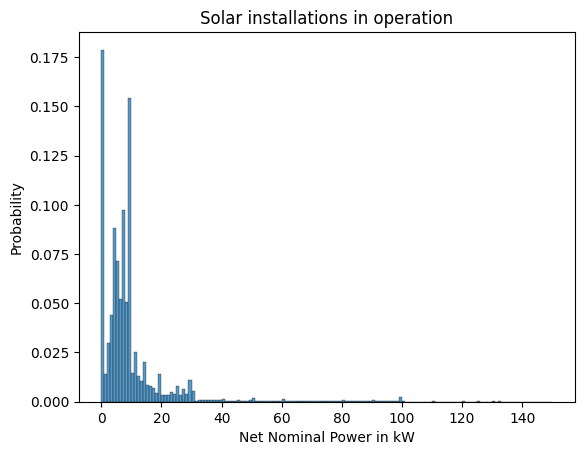

In [81]:
series = df_solar['Nettonennleistung']
series = exclude_outliers(series=series,
                          q_high=0.99,
                          q_low=0)
plot_distribution(series=series,
                  title='Solar installations in operation', 
                  x_label='Net Nominal Power in kW',
                  binwidth=1,
                  save_plot=save_plot,
                  save_name='pv_netpower.png')

### Orientation (Azimuth) Angle

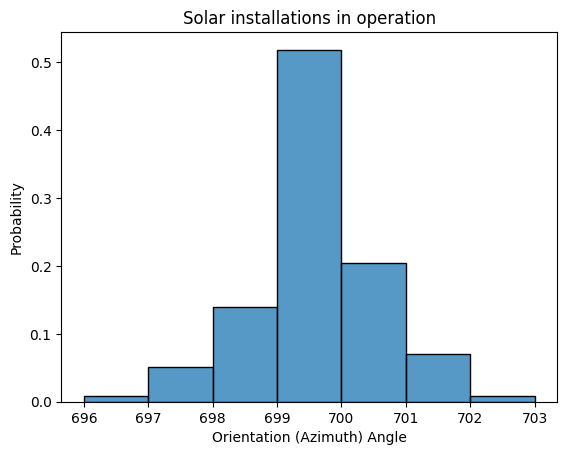

In [82]:
series = df_solar['Hauptausrichtung']
series = exclude_outliers(series=series,
                          q_high=1,
                          q_low=0)
plot_distribution(series=series,
                  title='Solar installations in operation', 
                  x_label='Orientation (Azimuth) Angle',
                  binwidth=1,
                  save_plot=save_plot,
                  save_name='pv_azimuth.png')

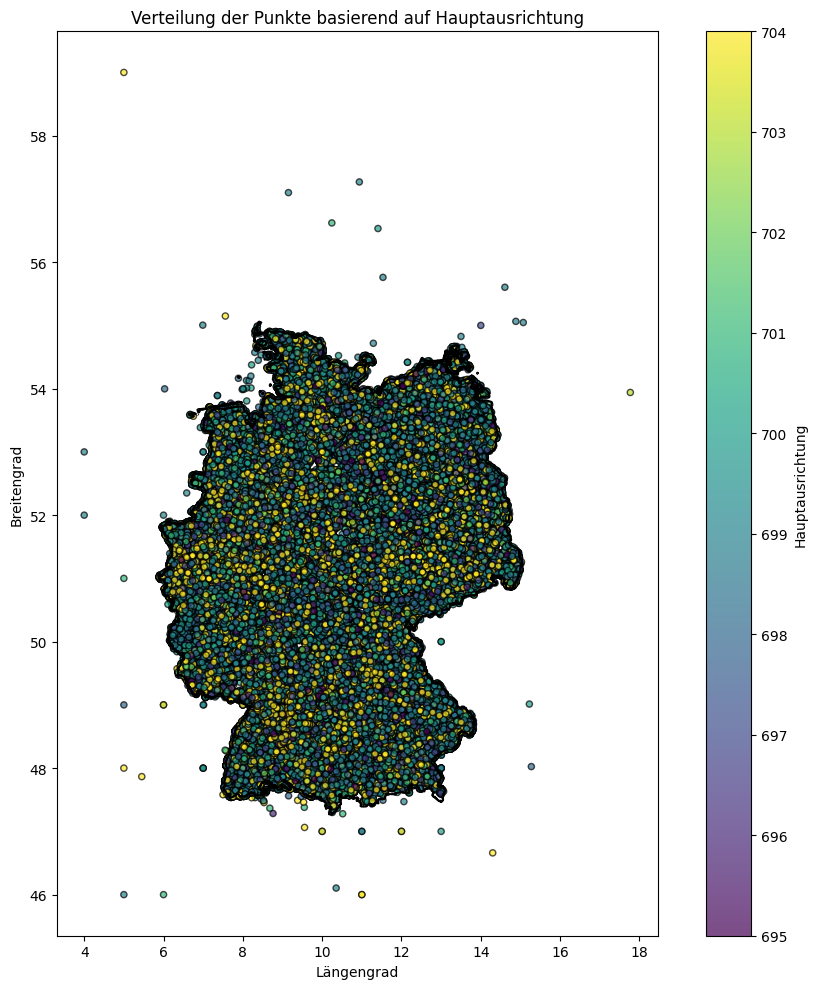

In [128]:
locs = df_solar[(~df_solar['Laengengrad'].isna()) & (~df_solar['Breitengrad'].isna())]

geojson_file = "geoBoundaries-DE.geojson"
germany = gpd.read_file(geojson_file)

# Scatterplot auf der Karte von Deutschland
fig, ax = plt.subplots(figsize=(10, 10))
germany.boundary.plot(ax=ax, color="black")

sc = ax.scatter(
    locs["Laengengrad"],
    locs["Breitengrad"],
    c=locs["Hauptausrichtung"],
    cmap="viridis",  # Farbkarte wählen
    s=20,  # Punktgröße
    edgecolor="k",
    alpha=0.7
)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Hauptausrichtung")

plt.title("Verteilung der Punkte basierend auf Hauptausrichtung")
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")
plt.tight_layout()
plt.show()

### Tilt Angle

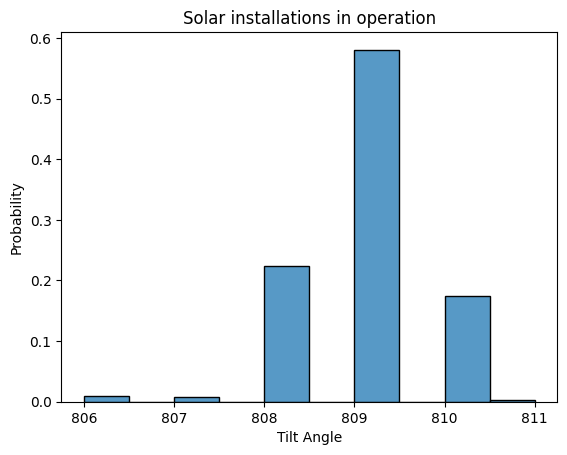

In [85]:
series = df_solar['HauptausrichtungNeigungswinkel']
plot_distribution(series=series,
                  title='Solar installations in operation', 
                  x_label='Tilt Angle',
                  bins=10,
                  save_plot=save_plot,
                  save_name='pv_tilt.png')

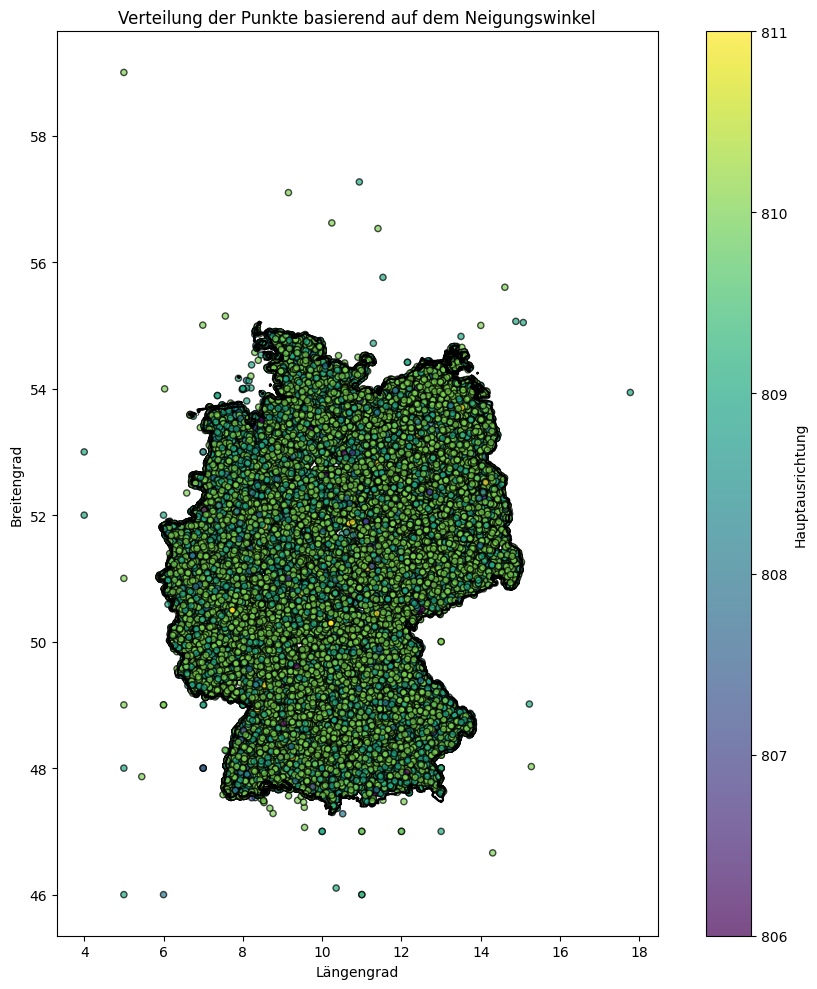

In [129]:
# Scatterplot auf der Karte von Deutschland
fig, ax = plt.subplots(figsize=(10, 10))
germany.boundary.plot(ax=ax, color="black")

sc = ax.scatter(
    locs["Laengengrad"],
    locs["Breitengrad"],
    c=locs["HauptausrichtungNeigungswinkel"],
    cmap="viridis",  # Farbkarte wählen
    s=20,  # Punktgröße
    edgecolor="k",
    alpha=0.7
)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Hauptausrichtung")

plt.title("Verteilung der Punkte basierend auf dem Neigungswinkel")
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")
plt.tight_layout()
plt.show()

### Number of modules

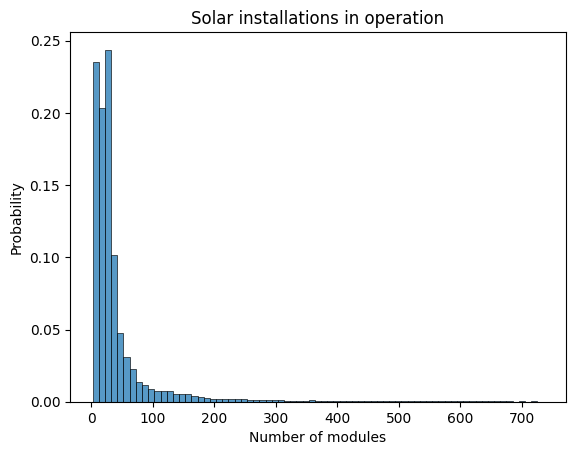

In [88]:
series = df_solar['AnzahlModule']
series = exclude_outliers(series=series,
                          q_high=0.99,
                          q_low=0.0)
plot_distribution(series=series,
                  title='Solar installations in operation', 
                  x_label='Number of modules',
                  binwidth=10,
                  save_plot=save_plot,
                  save_name='pv_nomodules.png')

## Wind Analysis

In [25]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38075 entries, 0 to 38074
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   EinheitMastrNummer           38075 non-null  object        
 1   EinheitBetriebsstatus        38075 non-null  int64         
 2   Postleitzahl                 36285 non-null  float64       
 3   Inbetriebnahmedatum          33371 non-null  datetime64[ns]
 4   DatumEndgueltigeStilllegung  1936 non-null   datetime64[ns]
 5   Breitengrad                  36983 non-null  float64       
 6   Laengengrad                  36983 non-null  float64       
 7   Nettonennleistung            38075 non-null  float64       
 8   Nabenhoehe                   37168 non-null  float64       
 9   Rotordurchmesser             37599 non-null  float64       
 10  NameWindpark                 37205 non-null  object        
 11  Hersteller                   37603 non-nu

Exclude the vertical wind turbines.

In [26]:
df_wind.drop(df_wind[df_wind['Technologie'] == 692.0].index, inplace=True)

Duration of operation

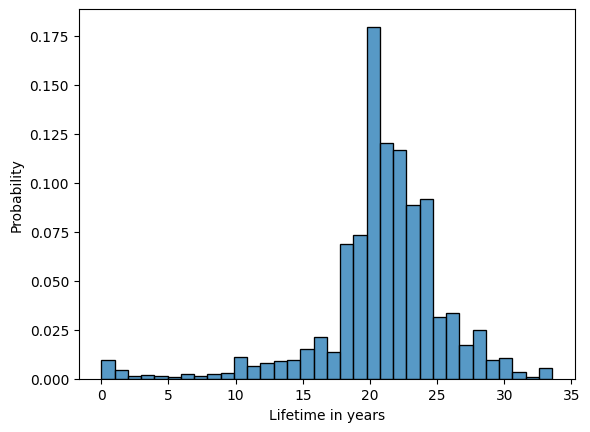

In [28]:
lifetime = get_lifetime(data=df_wind)
plot_distribution(series=lifetime, 
                  x_label='Lifetime in years', 
                  binwidth=1)

Exclude the closed systems.

In [29]:
df_wind.drop(df_wind[df_wind['EinheitBetriebsstatus'] != 35].index, inplace=True)

## Age

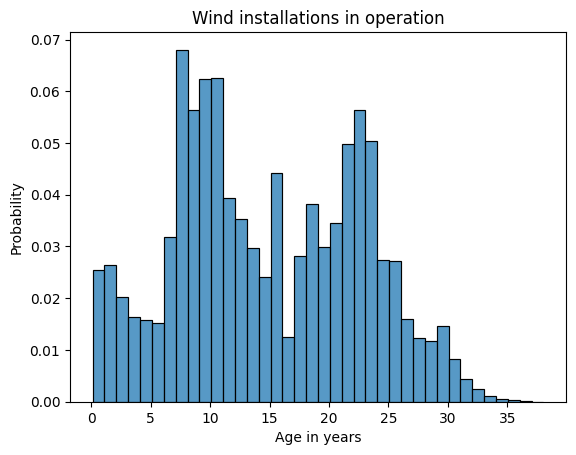

In [30]:
age = get_age(data=df_wind, q_high=1)
plot_distribution(series=age,
                  title='Wind installations in operation', 
                  x_label='Age in years',
                  binwidth=1,
                  save_plot=save_plot,
                  save_name='wind_age.png')

### Net Nominal Power

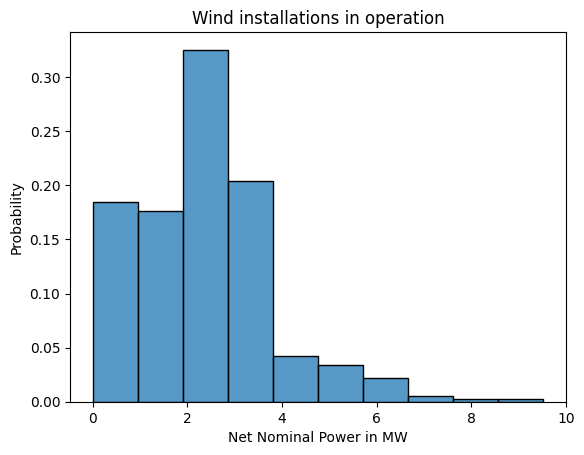

In [36]:
series = df_wind['Nettonennleistung'] / 1000
series = exclude_outliers(series=series,
                          q_high=1,
                          q_low=0)
plot_distribution(series=series,
                  title='Wind installations in operation', 
                  x_label='Net Nominal Power in MW',
                  binwidth=1,
                  save_plot=save_plot,
                  save_name='wind_netpower.png')

### Hub Height

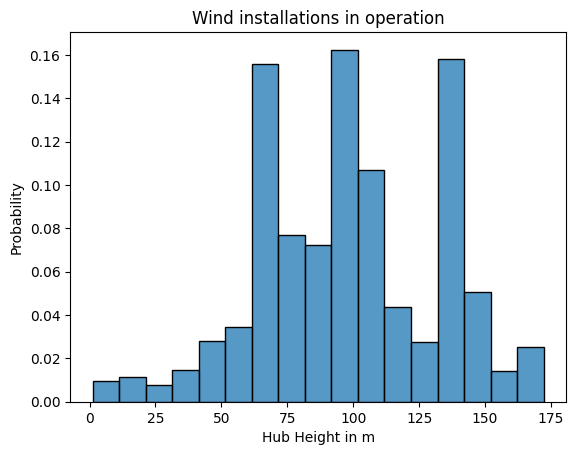

In [51]:
series = df_wind['Nabenhoehe']
series = exclude_outliers(series=series,
                          q_high=1,
                          q_low=0)
plot_distribution(series=series,
                  title='Wind installations in operation', 
                  x_label='Hub Height in m',
                  binwidth=10,
                  save_plot=save_plot,
                  save_name='wind_hubheight.png')

### Rotor Diameter

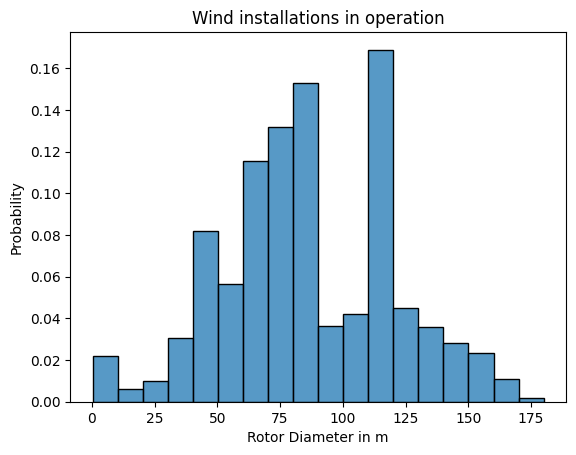

In [41]:
series = df_wind['Rotordurchmesser']
series = exclude_outliers(series=series,
                          q_high=1,
                          q_low=0)
plot_distribution(series=series,
                  title='Wind installations in operation', 
                  x_label='Rotor Diameter in m',
                  binwidth=10,
                  save_plot=save_plot,
                  save_name='wind_diameter.png')

In [44]:
print(f'There are {len(df_wind)} wind turbines installed and in operation.')

There are 30961 wind turbines installed and in operation.


In [131]:
turbines = df_wind.Typenbezeichnung.value_counts()

print(f'There are {len(turbines)} different turbine models installed. \n')
print('These are the shares relative to all turbines:')

turbine_shares = turbines / len(df_wind) * 100
turbine_shares[:25]

There are 3857 different turbine models installed. 

These are the shares relative all turbines:


Typenbezeichnung
E-70 E4         2.919802
E-82 E2         2.015439
E-115           1.947612
E-101           1.883014
E-82            1.782888
V90             1.589096
SWT-3.6-120     1.136914
V112            1.130454
V80             1.098156
E82             0.820387
N117            0.810697
E-53            0.801008
E-40            0.765479
E-66/18.70      0.749330
E-92            0.704112
V126            0.655664
E-70            0.636284
E-66/18.70-3    0.629825
E-66            0.616905
E-40/6.44       0.616905
E40             0.607216
E-138 EP3 E2    0.552308
MD77            0.549078
SWT-6.0-154     0.529699
3.2M114         0.516779
Name: count, dtype: float64

In [120]:
df_wind['Hersteller'] = df_wind['Hersteller'].apply(
    lambda x: mapping.get(x, 'Other') if isinstance(x, (int, float)) else x
)

In [121]:
manufacturer = df_wind['Hersteller'].value_counts()

print(f'{len(manufacturer)} manufacturers with more than 100 turbines installed. \n')
print('These are the shares relative all turbines:')

manufacturer_shares = manufacturer / len(df_wind) * 100
manufacturer_shares[:20]

18 manufacturers with more than 100 turbines installed. 

These are the shares relative all turbines:


Hersteller
Enercon        38.839185
Vestas         19.324311
Other           8.588224
Nordex          8.236168
GE Vernova      5.458480
Siemens         4.786667
Senvion         4.631633
Nordtank        3.181422
Tacke           1.098156
AN Bonus        1.062627
Fuhrlaender     1.014179
Dewind          0.868835
Adwen           0.633054
Eno Energy      0.507090
Suedwind        0.494170
Vensys          0.474791
EasyWind        0.419883
Gamesa          0.381125
Name: count, dtype: float64